# Pic Morph!

## setup

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import animation
import scipy
from scipy import optimize
import numpy as np
from tqdm.notebook import trange, tqdm

In [2]:
rng = np.random.default_rng()

In [3]:
skel_img = Image.open("./images/grey_wolf.jpg")
fill_img = Image.open("./images/rainbow_road.jpg")

In [4]:
dims = skel_img.size
fill_img = fill_img.resize(dims)

In [5]:
skel_arr = np.asarray(skel_img)
fill_arr = np.asarray(fill_img)

In [6]:
rows, cols, _ = skel_arr.shape

In [7]:
skel_arr.shape

(768, 1024, 3)

In [8]:
fill_arr.shape

(768, 1024, 3)

## helper functions

In [9]:
# def get_cost(x1, y1, x2, y2, A=skel_arr, B=fill_arr):
#     color = B[x2,y2] - A[x1,y1]
#     return np.linalg.norm(color)

In [10]:
# def get_cost(x1, y1, x2, y2, A=skel_arr, B=fill_arr):
#     dist = [x2-x1, y2-y1]
#     color = B[x2,y2] - A[x1,y1]
#     return np.linalg.norm(dist) + np.linalg.norm(color)  # can play around with weighting

In [11]:
# def clamp(val, maximum):
#     if val < 0:
#         return 0
#     if val >= maximum:
#         return maximum - 1
#     return val

## linear sum assignment alg V2

In [12]:
O = 25

r = rows // O
c = cols // O
        
cost_matrix = np.empty((r,c,r,c))

In [13]:
for i in trange(r):
    for j in trange(c, leave=False):
        avg_skel = np.average(skel_arr[i*O:i*O+O, j*O:j*O+O], axis=(0,1))
        for i2 in range(r):
            for j2 in range(c):
                avg_fill = np.average(fill_arr[i2*O:i2*O+O, j2*O:j2*O+O], axis=(0,1))
                cost_matrix[i,j,i2,j2] = np.linalg.norm(avg_fill - avg_skel)


temp = cost_matrix.reshape(r, c, r*c).transpose(2,0,1).reshape(r*c, r*c).transpose(1,0)
_, col_ind = optimize.linear_sum_assignment(temp)

coords = col_ind.reshape(r,c)

In [14]:
final_arr = np.empty((rows, cols, 3), dtype=int)

for i in range(r):
    for j in range(c):
        temp = coords[i,j]
        i2 = temp // c
        j2 = temp % c
        
        final_arr[i*O:i*O+O, j*O:j*O+O] = fill_arr[i2*O:i2*O+O, j2*O:j2*O+O].copy()

In [15]:
interp_coef = 50
interp_arrs = np.zeros((interp_coef, rows, cols, 3), dtype=int)
interp_domain = np.linspace(0, 1, num=interp_coef)

for k, val in enumerate(tqdm(interp_domain)):
    for i in range(r):
        for j in range(c):
            temp = coords[i,j]
            i2 = temp // c
            j2 = temp % c
            
            i3 = int(i * (1 - val) + i2 * val)
            j3 = int(j * (1 - val) + j2 * val)

            interp_arrs[k, i*O:i*O+O, j*O:j*O+O] = fill_arr[i3*O:i3*O+O, j3*O:j3*O+O].copy()

## linear sum assignment alg V1

In [16]:
# final_arr = np.empty((rows, cols, 3))

# O = 32

# for I in trange(rows // O):
#     i_base = O * I
#     for J in trange(cols // O, leave=False):
#         j_base = O * J
        
#         cost_matrix = np.empty((O,O,O,O))
        
#         for i in range(O):
#             for j in range(O):
#                 for i2 in range(O):
#                     for j2 in range(O):
#                         cost_matrix[i, j, i2, j2] = get_cost(i_base + i, j_base + j, i_base + i2, j_base + j2)
        
        
#         temp = cost_matrix.reshape(O, O, O*O).transpose(2,0,1).reshape(O*O, O*O).transpose(1,0)
#         _, col_ind = optimize.linear_sum_assignment(temp)
        
#         coords = col_ind.reshape(O,O)
        
#         for i in range(O):
#             for j in range(O):
#                 composite2 = coords[i,j]
#                 i2 = composite2 // O
#                 j2 = composite2 % O
#                 final_arr[i_base + i, j_base + j] = fill_arr[i_base + i2, j_base + j2]#.copy()

## local greedy-ish alg

In [17]:
# coords = np.empty((rows, cols, 2), dtype=int)
# for i in range(rows):
#     for j in range(cols):
#         coords[i,j] = [i,j]
        
# inv_coords = np.empty((rows, cols, 2), dtype=int)  # inv_coords(coords(i,j)) = (i,j)
# for i in range(rows):
#     for j in range(cols):
#         inv_coords[i,j] = [i,j]

In [18]:
# window = 30

In [19]:
# row_domain = np.arange(rows, step=10)
# col_domain = np.arange(cols, step=10)

In [20]:
# for i in tqdm(row_domain):
#     for j in tqdm(col_domain, leave=False):
#         x,y = coords[i,j]

#         base_cost = get_cost(x, y, i, j)

#         for x_delta in range(-window, window):
#             x_new = clamp(x + x_delta, rows)
#             for y_delta in range(-window, window):
#                 y_new = clamp(y + y_delta, cols)

#                 new_cost = get_cost(x_new, y_new, i, j)

#                 if new_cost < base_cost:
#                     x = x_new
#                     y = y_new
#                     base_cost = new_cost

        
#         temp_x, temp_y = coords[i,j]
#         inv_temp_x, inv_temp_y = inv_coords[x,y]
        
#         coords[i,j] = [x,y]
#         inv_coords[x,y] = [i,j]
        
#         coords[inv_temp_x, inv_temp_y] = [temp_x, temp_y]
#         inv_coords[temp_x, temp_y] = [inv_temp_x, inv_temp_y]

In [21]:
# final_arr = np.empty((rows, cols, 3), dtype=int)
# for i in range(rows):
#     for j in range(cols):
#         x,y = coords[i,j]
#         final_arr[i,j] = skel_arr[x,y]

## display final image

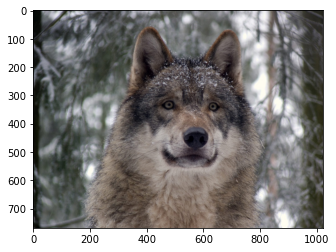

In [22]:
%matplotlib inline
plt.imshow(skel_arr);

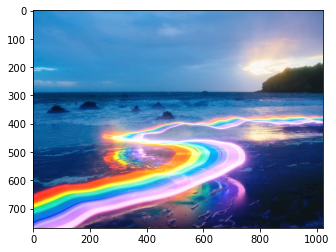

In [23]:
%matplotlib inline
plt.imshow(fill_arr);

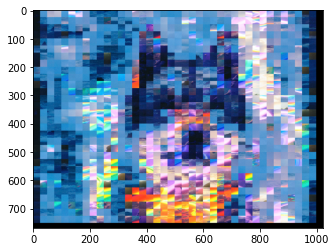

In [24]:
%matplotlib inline
plt.imshow(final_arr);

<IPython.core.display.Javascript object>


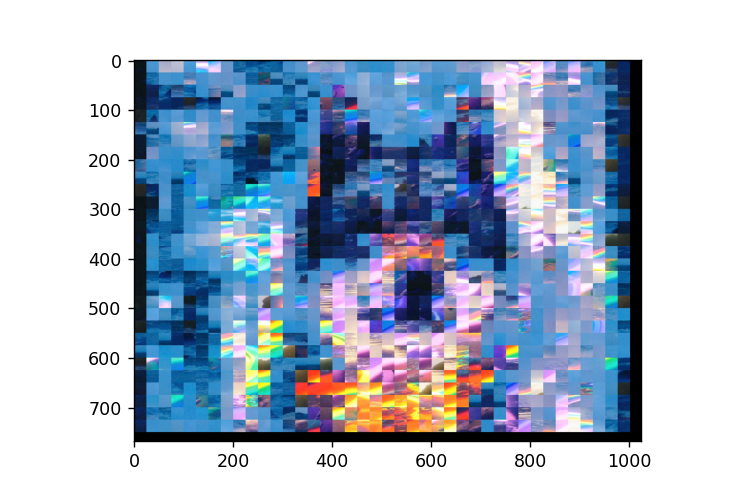

In [27]:
%matplotlib notebook
fig = plt.figure()

plt.imshow(final_arr)

ims = []
for k in range(interp_coef):
    im = plt.imshow(interp_arrs[k], animated=True)
    ims.append([im])


ani = animation.ArtistAnimation(fig, ims, interval=40, blit=True, repeat_delay=5000)

# ani.save('dynamic_images.mp4')

plt.show()